Identify rotational cluster states in H2S at $J\sim 40..60$

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")

import itertools
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from PIL import Image

from rovib.symtop import symtop_on_grid_split_angles

PMAX = 24

Read pure rotational states, computed and stored in `h2s_rovib.ipynb`, plot rotational energy level diagram.

In [2]:
def select_states_vib0(j: int, pmax: int = 24):
    """Selects states with the (0, 0, 0) assignment for vibrational quanta,
    i.e., rotational states belonging to the ground vibrational state.

    Returns a list of states, where each state is represented as a tuple in the format:
    (rotational quantum number J, state index, state energy, state assignment with quanta).
    The `state assignment with quanta` is a list containing the following elements:
        - total symmetry
        - J, rotational quantum number
        - v1, vibrational quantum number for mode 1
        - v2, vibrational quantum number for mode 2
        - v3, vibrational quantum number for mode 3
        - vibrational symmetry
        - k, rotational quantum number 
        - tau, rotational parity
        - rotational symmetry
    """
    h5 = h5py.File(f"pmax{pmax}/h2s_coefficients_pmax{pmax}_j{j}.h5", "r")
    energies = []
    energy_ind = []
    quanta = []
    for sym in h5["energies"].keys():
        enr = h5["energies"][sym][:]
        coefs = h5["coefficients"][sym][:]
        qua = np.array(
            [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
        )
        state_qua = qua[np.argmax(np.abs(coefs) ** 2, axis=0)]
        vib_qua = state_qua[:, 2:5]
        ground_state_ind = np.where(
            (vib_qua[:, 0] == "0") & (vib_qua[:, 1] == "0") & (vib_qua[:, 2] == "0")
        )[0]
        energies.append(enr[ground_state_ind])
        energy_ind.append(ground_state_ind)
        quanta.append(state_qua[ground_state_ind])

    energies = np.concatenate(energies, axis=0)
    energy_ind = np.concatenate(energy_ind, axis=0)
    quanta = np.concatenate(quanta, axis=0)
    ind = np.argsort(energies)
    energies = energies[ind]
    energy_ind = energy_ind[ind]
    quanta = quanta[ind].tolist()
    states = [(j, i, e, q) for i, e, q in zip(energy_ind, energies, quanta)]
    return states

In [3]:
min_j = 0
max_j = 60

rot_states = {}

for j in range(min_j, max_j+1):
    rot_states[j] = select_states_vib0(j, pmax=PMAX)

To observe the clustering effect, for each $J$ multiplet subtract the uppermost energy $E_{J,k,\tau}^\text{(max)}$ from all the energy levels lying below.

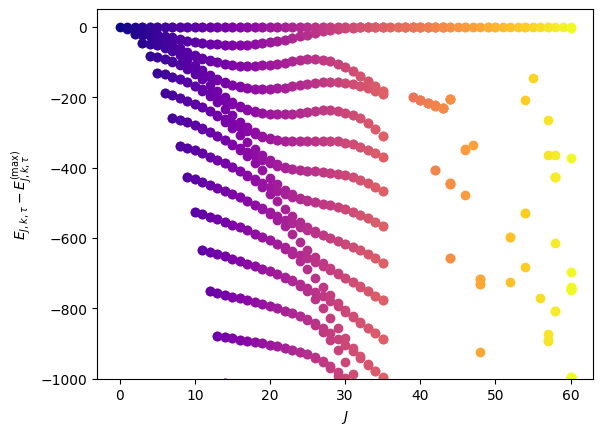

In [4]:
max_j = max(list(rot_states.keys()))

for j, states in rot_states.items():
    upper_enr = states[-1][2]
    # subtract the highest state energy (list is sorted wrt energy)
    enr = [state[2] - upper_enr for state in states]
    plt.scatter([j for _ in range(len(enr))], enr, color=cm.plasma(j / max_j))

plt.xlabel("$J$")
plt.ylabel("$E_{J,k,\\tau}-E_{J,k,\\tau}^\\text{(max)}$")
plt.ylim([-1000, 50])
plt.show()

From the plot, it's clear that the state assignments by vibrational quanta are incorrect for states with $J>35$. This indicates contributions to the vibrational ground state from excited vibrational states, which ultimately cause the rotational clustering effect.

To identify which states form clusters, we can plot the rotational density for a subset of states preselected as potential candidates and visually inspect these plots.

First, let's fit the energy of cluster states for $J=0..35$ using a simple function $E_{J,k,\tau}^\text{max}=BJ(J+1)$. With this function, we can estimate the upper bound for the cluster state energy for states with $J>35$.

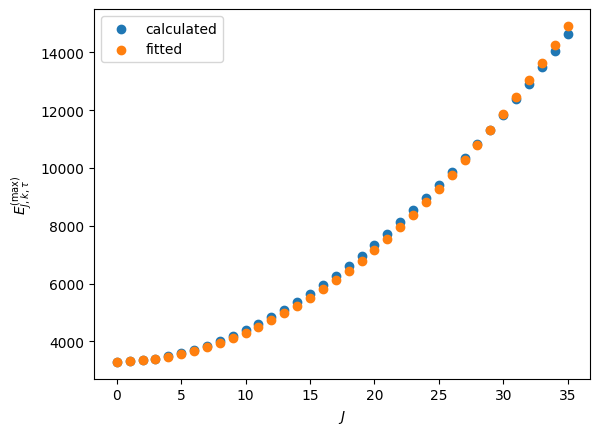

In [5]:
upper_enr = np.array(
    [states[-1][2] for j, states in rot_states.items() if j <= 35]
)
j_list = np.array([j for j in rot_states.keys() if j <= 35])

zpe = upper_enr[0]
b_const_upper = np.sum((upper_enr-zpe) * j_list * (j_list+1) ) / np.sum(
    j_list**2 * (j_list +1)**2
)
upper_enr_func = lambda j: zpe + b_const_upper * j * (j+1)

plt.scatter(j_list, upper_enr, label="calculated")
plt.scatter(j_list, [upper_enr_func(j) for j in j_list], label="fitted")
plt.xlabel("$J$")
plt.ylabel("$E_{J,k,\\tau}^\\text{(max)}$")
plt.legend()
plt.show()

Next, preselect sets of states for each $J=36..60$ that are four-fold nearly-degenerate with symmetries $A_1$, $B_1$, $A_2$, and $B_2$
and lie within the specified energy range. The maximum energy is estimated using the fitted $BJ(J+1)$ function, while the minimum is determined by the energy of the cluster state with $J$ one unit smaller than the current value.

In [6]:
def select_cluster_states(
    j: int, lower_enr: float, upper_enr: float, pmax: int = 24, tol: float = 1e-3
):
    """Selects sets of states as possible candidates for rotational cluster states,
    based of four-fold degeneracy of states with symmetries A1, A2, B1, and B2
    """
    h5 = h5py.File(f"pmax{pmax}/h2s_coefficients_pmax{pmax}_j{j}.h5", "r")
    energies = []
    symmetries = []
    energy_ind = []
    quanta = []
    for sym in h5["energies"].keys():
        enr = h5["energies"][sym][:]
        coefs = h5["coefficients"][sym][:]
        qua = np.array(
            [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
        )
        energies.append(enr)
        symmetries.append([sym for _ in range(len(enr))])
        energy_ind.append([i for i in range(len(enr))])
        quanta.append(qua[np.argmax(np.abs(coefs) ** 2, axis=0)])

    energies = np.concatenate(energies, axis=0)
    symmetries = np.concatenate(symmetries, axis=0)
    energy_ind = np.concatenate(energy_ind, axis=0)
    quanta = np.concatenate(quanta, axis=0)
    ind = np.argsort(energies)
    energies = energies[ind]
    symmetries = symmetries[ind]
    energy_ind = energy_ind[ind]
    quanta = quanta[ind]

    cluster_states = []
    for i in range(len(energies) - 4):
        enr_list = energies[i : i + 4]
        sym_list = symmetries[i : i + 4]
        qua = quanta[i : i + 4].tolist()
        enr_ind = energy_ind[i : i + 4]
        # cluster-states conditions
        if (
            np.all(enr_list >= lower_enr)
            and np.all(enr_list <= upper_enr)
            and np.all(np.abs(enr_list - enr_list[0]) < tol)
            and ",".join(sorted(sym_list)) == "A1,A2,B1,B2"
        ):
            cluster_states.append(
                [(j, i, e, q) for i, e, q in zip(enr_ind, enr_list, qua)]
            )
    return cluster_states

In [7]:
# preselect states that can be cluster states

min_j = 36
max_j = 60

lower_enr = rot_states[min_j - 1][-1][2]
cluster_states = {}
for j in range(min_j, max_j + 1):
    upper_enr = upper_enr_func(j)
    print(
        f"J = {j}, lower energy estimate = {lower_enr}, upper energy estimate = {upper_enr}"
    )
    cluster_states[j] = select_cluster_states(
        j=j, lower_enr=lower_enr, upper_enr=upper_enr, tol=1, pmax=PMAX
    )
    lower_enr = cluster_states[j][0][0][2]
    for state in cluster_states[j]:
        print(state)

J = 36, lower energy estimate = 14641.144565455548, upper energy estimate = 15578.671850746425
[(36, 71, 15239.31670086952, ['B2', '36', '0', '0', '0', 'A1', '29', '0', 'B2']), (36, 61, 15239.316701835345, ['A2', '36', '0', '0', '0', 'A1', '29', '1', 'A2']), (36, 72, 15239.452640722675, ['A1', '36', '0', '0', '0', 'A1', '30', '0', 'A1']), (36, 61, 15239.45269195183, ['B1', '36', '0', '0', '0', 'A1', '30', '1', 'B1'])]
[(36, 71, 15462.586475034095, ['B1', '36', '1', '0', '2', 'B2', '11', '1', 'A2']), (36, 71, 15462.586475034375, ['A2', '36', '1', '0', '2', 'B2', '12', '1', 'B1']), (36, 77, 15462.904066017916, ['B2', '36', '1', '0', '3', 'A1', '1', '0', 'B2']), (36, 79, 15462.904066020637, ['A1', '36', '1', '0', '3', 'A1', '2', '0', 'A1'])]
J = 37, lower energy estimate = 15239.31670086952, upper energy estimate = 16261.311386725267
[(37, 60, 15433.629238177447, ['B1', '37', '0', '0', '4', 'A1', '6', '1', 'B1']), (37, 60, 15433.629238456679, ['A2', '37', '0', '0', '4', 'A1', '5', '1', 'A

Finally, to identify the highest-energy cluster states withing the ground vibrational state, plot rotational densities for all cluster-state candidates for different $J$ quanta and select the correct states by visually ispeciting these density images. 

In [15]:
def dens_on_grid(
    j: int,
    sym: str,
    state_ind: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    gamma: np.ndarray,
    pmax: int = 24,
):
    """Computes reduced rotational probability density function
    for rovibrational selected state on a grid of Euler angles
    """
    rot_k, rot_m, rot_mu, k_list, jktau_list = symtop_on_grid_split_angles(
        j, alpha, beta, gamma
    )

    h5 = h5py.File(f"pmax{pmax}/h2s_coefficients_pmax{pmax}_j{j}.h5", "r")
    enr = h5["energies"][sym][state_ind]
    coefs = h5["coefficients"][sym][:, state_ind]
    vib_ind = h5["vib-indices"][sym][:]
    rot_ind = h5["rot-indices"][sym][:]

    rot_k = rot_k[rot_ind]
    vib_ind_unique = list(set(vib_ind))
    v_ind = [np.where(vib_ind == ind)[0] for ind in vib_ind_unique]
    unique_vec = np.zeros((len(vib_ind), len(vib_ind_unique)))
    for i, v in enumerate(v_ind):
        unique_vec[v, i] = 1
    rot_kv = np.einsum(
        "i...,img,iv->mvg...", coefs, rot_k, unique_vec, optimize="optimal"
    )

    den_kv = np.einsum(
        "ivg,jvg->ijg",
        np.conj(rot_kv[:, vib_ind]),
        rot_kv[:, vib_ind],
        optimize="optimal",
    )
    den_m = np.einsum("mig,mjg->mijg", np.conj(rot_m), rot_m, optimize="optimal")
    den_mu = np.einsum("ig,jg->ijg", np.conj(rot_mu), rot_mu, optimize="optimal")
    dens = np.einsum(
        "ijg,ija,ijb,b->abg",
        den_kv,
        den_m[-1],
        den_mu,
        np.sin(beta),
        optimize="optimal",
    )
    return dens, enr

In [16]:
def store_density_file(
    j: int,
    sym: str,
    state_ind: int,
    alpha,
    beta,
    gamma,
    euler_mesh,
    filename: str,
    title: str,
):
    """Plots rotational probability density as function of the Euler angles
    beta and gamma and stores it in file
    """
    dens, enr = dens_on_grid(j, sym, state_ind, alpha, beta, gamma, pmax=PMAX)
    dens = np.real(dens)

    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(projection="3d")
    ax.set_box_aspect(aspect=(1, 1, 1))
    ax.axes.set_xlim3d(left=-1.5, right=1.5)
    ax.axes.set_ylim3d(bottom=-1.5, top=1.5)
    ax.axes.set_zlim3d(bottom=-1.5, top=1.5)

    theta, phi = euler_mesh
    npoints = len(theta)
    d = dens.reshape(npoints, -1).T
    r = d / np.max(d) + 1
    r = r.reshape(npoints, -1)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    ax.plot_surface(x, y, z, facecolors=cm.jet(r / np.amax(r)), rstride=1, cstride=1)
    plt.title(title)
    plt.savefig(filename)
    plt.close()


def stack_images(image_files, output_file):
    images = [Image.open(image_file) for image_file in image_files]
    widths, heights = zip(*(img.size for img in images))
    stacked_image = Image.new("RGB", (max(widths), sum(heights)))
    y_offset = 0
    for img in images:
        stacked_image.paste(img, (0, y_offset))
        y_offset += img.height
    stacked_image.save(output_file)

In [17]:
# create small grid of Euler angles beta and gamma (fix alpha angle to 0)
npoints = 60
alpha = np.array([0])
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)
euler_grid = np.array([elem for elem in itertools.product(alpha, beta, gamma)])
mesh = np.meshgrid(beta, gamma)

# generate densities for different cluster state candidates
# and store them in single file for every J quanta

for j in cluster_states.keys():

    if j != 55: # restart
        continue

    no_candidates = len(cluster_states[j])
    file_list = []
    for icand in range(no_candidates):
        sym = cluster_states[j][icand][0][3][0]
        state_ind = cluster_states[j][icand][0][1]
        title = f"({j}, {sym}, {state_ind})"
        filename = f"dens_{j}_{icand}.png"
        # print(icand, sym, state_ind)
        store_density_file(
            j, sym, state_ind, alpha, beta, gamma, mesh, filename, title
        )
        file_list.append(filename)
    stack_images(file_list, f"etc/density_assignment/pmax{PMAX}/stack_dens_j{j}.png")
    for filename in file_list:
        os.remove(filename)

0 B1 133
1 B1 138
2 A1 139
3 B2 153
4 A2 182
5 B1 207
6 A2 215
7 B2 194
8 B1 223
9 B1 236
10 A2 238
11 B2 214
12 B2 215
13 B1 247
14 B2 219
15 A2 261
16 B2 229
17 B2 255
18 B2 269
19 B2 271
20 A1 270
21 B1 306
22 B1 310
23 B1 336
24 B1 339
25 B2 313
26 B2 319
27 B1 363
28 B2 327
29 B2 330
30 A1 329
31 B1 397
32 B2 368
33 B2 370
34 B1 410
35 A2 411
36 B1 414
37 B2 379
38 B2 386
39 B2 389
40 A1 387
41 A1 396
42 B1 451
43 A2 450
44 A1 402
45 B2 405
46 A1 405
47 B2 414
48 B2 418
49 B1 465
50 B1 475
51 B1 483
52 B2 437
53 A2 486
54 B2 438
55 B2 441
56 B1 495
57 B1 497
58 B1 502
59 B2 451
60 A1 449
61 B1 503
62 A1 454
63 A1 462
64 B1 516
65 B2 471
66 B2 473
67 B2 480
68 A2 535
69 B2 485
70 A1 491
71 A1 501
72 A1 504
73 A2 564
74 B1 565
75 A1 505
76 A2 565
77 A2 572
78 A2 579
79 B2 524
80 A1 526
81 B1 588
82 A1 540
83 B1 601
84 A2 602
85 B2 547
86 B1 607
87 A2 612
88 B1 614
89 A1 557
90 B1 622
91 B2 570
92 A1 572
93 B1 631
94 B2 585
95 A2 644
96 B1 651
97 A1 596
98 B1 664
99 B1 668
100 B1 672

Create a list of state indices for all cluster states (uppermost energy states for each $J$ multiplet) for $J=36..60$

In [8]:
# identify symmetry and id of the lowest energy cluster state for each J=36..60
#   by visually inspecting files with density plots, generated by running the previous cell

cluster_state_ind = {
    36: ("B2", 71),
    37: ("A1", 70),
    38: ("B2", 87),
    39: ("A1", 85),
    40: ("B2", 104),
    41: ("A1", 101),
    42: ("B2", 129),
    43: ("B1", 146),
    44: ("A2", 145),
    45: ("B1", 174),
    46: ("A2", 170),
    47: ("A2", 208),
    48: ("A2", 205),
    49: ("A1", 224),
    50: ("B2", 277),
    51: ("B1", 299),
    52: ("B2", 324),
    53: ("A1", 316),
    54: ("B2", 385),
    55: ("B1", 414),
    56: ("A2", 399),
    57: ("A1", 433),
    58: ("A2", 472),
    59: ("A2", 567),
    60: ("B1", 544),
}

max_j = max(list(rot_states.keys()))
for j, states in rot_states.items():
    if j <= 35:
        cluster_state_ind[j] = (states[-1][3][0], states[-1][1])

Based on the indices of the uppermost-energy rotational states for each $J$, identify their energies together with the other states that belong to the four-fold clusters.

In [9]:
def select_cluster_states_id(j: int, ref_sym: str, ref_ind: int, pmax: int = 24):
    """Selects sets of cluster states based on the four-fold degeneracy
    and symmetry and id number of the lowest state in the cluster group
    """
    h5 = h5py.File(f"pmax{pmax}/h2s_coefficients_pmax{pmax}_j{j}.h5", "r")
    energies = []
    symmetries = []
    energy_ind = []
    quanta = []
    for sym in h5["energies"].keys():
        enr = h5["energies"][sym][:]
        coefs = h5["coefficients"][sym][:]
        qua = np.array(
            [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
        )
        energies.append(enr)
        symmetries.append([sym for _ in range(len(enr))])
        energy_ind.append([i for i in range(len(enr))])
        # quanta.append(qua[np.argmax(np.abs(coefs) ** 2, axis=0)[0]])
        quanta.append(qua[np.argmax(np.abs(coefs) ** 2, axis=0)])

    energies = np.concatenate(energies, axis=0)
    symmetries = np.concatenate(symmetries, axis=0)
    energy_ind = np.concatenate(energy_ind, axis=0)
    quanta = np.concatenate(quanta, axis=0)
    ind = np.argsort(energies)
    energies = energies[ind]
    symmetries = symmetries[ind]
    energy_ind = energy_ind[ind]
    quanta = quanta[ind]

    cluster_states = []
    for i in range(len(energies) - 4):
        enr_list = energies[i : i + 4]
        sym_list = symmetries[i : i + 4]
        qua = quanta[i : i + 4].tolist()
        enr_ind = energy_ind[i : i + 4]
        # cluster-states conditions
        if enr_ind[0] == ref_ind and sym_list[0] == ref_sym:
            cluster_states.append(
                [(j, i, e, q) for i, e, q in zip(enr_ind, enr_list, qua)]
            )
    return cluster_states

In [10]:
# run the above function to extract all states components of degenerate clusters
#   and store data in file

cluster_states = {}
for j, (ref_sym, ref_ind) in cluster_state_ind.items():
    cluster_states[j] = select_cluster_states_id(j, ref_sym, ref_ind, pmax=PMAX)
    for states in cluster_states[j]:
        print(states)

with open(f"h2s_cluster_states_id_pmax{PMAX}.txt", "w") as fl:
    for j, state in cluster_states.items():
        cluster_group = state[0]
        fl.write(
            "   ".join(
                f"{j_:3d} {id:6d} {e:20.10f}" + " ".join(f" {q}" for q in qua)
                for (j_, id, e, qua) in cluster_group
            )
            + "\n"
        )

[(36, 71, 15239.31670086952, ['B2', '36', '0', '0', '0', 'A1', '29', '0', 'B2']), (36, 61, 15239.316701835345, ['A2', '36', '0', '0', '0', 'A1', '29', '1', 'A2']), (36, 72, 15239.452640722675, ['A1', '36', '0', '0', '0', 'A1', '30', '0', 'A1']), (36, 61, 15239.45269195183, ['B1', '36', '0', '0', '0', 'A1', '30', '1', 'B1'])]
[(37, 70, 15849.750371866696, ['A1', '37', '0', '0', '0', 'A1', '30', '0', 'A1']), (37, 78, 15849.750372524337, ['B1', '37', '0', '0', '0', 'A1', '30', '1', 'B1']), (37, 78, 15849.823181654598, ['A2', '37', '0', '0', '0', 'A1', '29', '1', 'A2']), (37, 72, 15849.823181708325, ['B2', '37', '0', '0', '0', 'A1', '29', '0', 'B2'])]
[(38, 87, 16471.845248390793, ['B2', '38', '0', '0', '0', 'A1', '31', '0', 'B2']), (38, 75, 16471.845248912494, ['A2', '38', '0', '0', '0', 'A1', '31', '1', 'A2']), (38, 75, 16471.88366504116, ['B1', '38', '0', '0', '0', 'A1', '30', '1', 'B1']), (38, 89, 16471.8836650491, ['A1', '38', '0', '0', '0', 'A1', '30', '0', 'A1'])]
[(39, 85, 17105.24

Plot the energies of cluster states

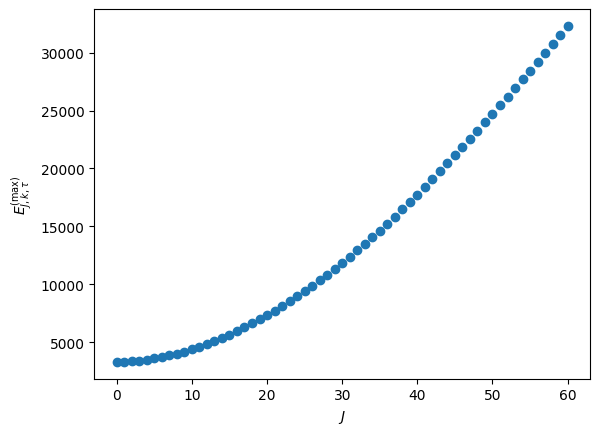

In [11]:
j_list = [j for j in cluster_states.keys()]
enr_list = [elem[0][0][2] for elem in cluster_states.values()]
plt.scatter(j_list, enr_list)
plt.xlabel("$J$")
plt.ylabel("$E_{J,k,\\tau}^\\text{(max)}$")
plt.show()

Just for plotting of the rotational energy level diagram, we may select again rotational states based on the leading contribution from the pure vibrational state but also considering states for which the pure vibrational state enters as the second, third, or fourth leading contribution.

In [14]:
def select_states_vib0_ext(j: int, pmax: int = 24):
    """Selects states with the (0, 0, 0) assignment for vibrational quanta,
    where (0, 0, 0 ) corresponds to the first, second, third, or fourth leading contribution.
    """
    h5 = h5py.File(f"pmax{pmax}/h2s_coefficients_pmax{pmax}_j{j}.h5", "r")
    energies = []
    energy_ind = []
    quanta = []
    for sym in h5["energies"].keys():
        enr = h5["energies"][sym][:]
        coefs = h5["coefficients"][sym][:]
        qua = np.array(
            [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
        )
        for i in range(4): # first, second, third, or fourth largest contribuions from (0,0,0)
            state_qua = qua[np.argmax(np.abs(coefs) ** 2, axis=0)]
            vib_qua = state_qua[:, 2:5]
            ground_state_ind = np.where(
                (vib_qua[:, 0] == "0") & (vib_qua[:, 1] == "0") & (vib_qua[:, 2] == "0")
            )[0]
            energies.append(enr[ground_state_ind])
            energy_ind.append(ground_state_ind)
            quanta.append(state_qua[ground_state_ind])
            max_ind = np.argmax(np.abs(coefs) ** 2, axis=0)
            for i in range(coefs.shape[-1]):
                coefs[max_ind[i], i] = 0

    energies = np.concatenate(energies, axis=0)
    energy_ind = np.concatenate(energy_ind, axis=0)
    ind = np.argsort(energies)
    energies = energies[ind]
    energy_ind = energy_ind[ind]
    states = [(j, i, e) for i, e in zip(energy_ind, energies)]
    return states

In [15]:
# select states using the function above

max_j = 60
rot_states_ext = {}
for j in range(max_j):
    rot_states_ext[j] = select_states_vib0_ext(j, pmax=PMAX)

In [18]:
with open(f"cluster_states_plot_pmax{PMAX}.txt", "w") as fl:
    for j, states in rot_states_ext.items():
        if j <= 35:
            upper_enr = rot_states[j][-1][2]
        else:
            upper_enr = cluster_states[j][0][0][2]
        enr = [state[2] - upper_enr for state in states]
        out_str = f"{j}" + " " + " ".join("%20.10f" % e for e in enr)
        fl.write(out_str + "\n")

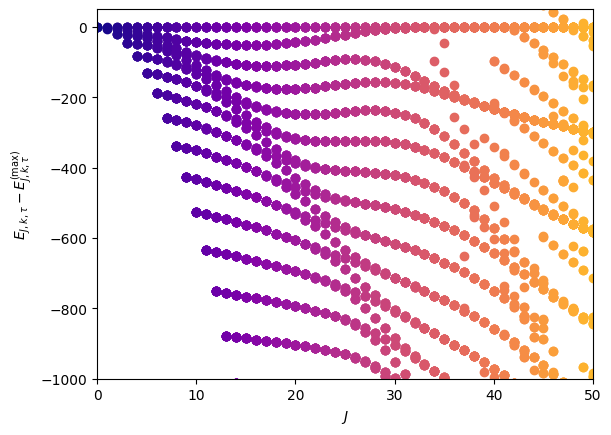

In [17]:
# plot rotational energy level diagram

max_j = max(list(rot_states_ext.keys()))
for j, states in rot_states_ext.items():
    # subtract the highest state energy (list is sorted wrt energy)
    if j <= 35:
        upper_enr = rot_states[j][-1][2]
    else:
        upper_enr = cluster_states[j][0][0][2]
    enr = [state[2] - upper_enr for state in states]
    plt.scatter(
        [j for _ in range(len(enr))], enr, color=cm.plasma(j / max_j)
    )

plt.xlabel("$J$")
plt.ylabel("$E_{J,k,\\tau}-E_{J,k,\\tau}^\\text{(max)}$")
plt.ylim([-1000, 50])
plt.xlim([0, 50])
plt.show()